# AP Koller Internship Assignment
## Sahil Nagaralu
## AIML
## Symbiosis Institue of Technology

### Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

## Importing Dataset

In [2]:
train_dataset = pd.read_csv("dataset/Training Dataset.csv")
train_dataset.head()

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
0,NTM3,X1,A28,WHOLESALE,Large,Powder,May-21,10.16
1,NTM2,X1,A9,DIRECT,Large,Powder,Oct-20,134.28
2,NTM3,X2,A20,DIRECT,Large,Powder,Dec-20,12.46
3,NTM3,X1,A18,WHOLESALE,Small,Powder,Feb-21,107.22
4,NTM2,X1,A28,DIRECT,Large,Liquid,Nov-20,197.76


### Checking For null values

In [3]:
train_dataset.isnull().sum()

ProductType          0
Manufacturer         0
Area Code            0
Sourcing Channel     0
Product Size         0
Product Type         0
Month of Sourcing    0
Sourcing Cost        0
dtype: int64

### Converting the given Month column into two columns Month and Year

In [4]:
train_dataset['Month of Sourcing'] = pd.to_datetime(train_dataset['Month of Sourcing'], format='%b-%y')
train_dataset['Year'] = train_dataset['Month of Sourcing'].dt.year
train_dataset['Month'] = train_dataset['Month of Sourcing'].dt.month
# Not removing the Month of Sourcing Column for EDA

### Encoding all the Input Features which are Categorical

In [5]:
encoders = {}
for column in train_dataset.columns:
    if train_dataset.dtypes[column] == 'object':
        encoder = LabelEncoder()
        encoder.fit(train_dataset[column])
        train_dataset[column] = encoder.transform(train_dataset[column])
        encoders[column] = encoder

### The Box Plot of Sorcing Cost with Outliers

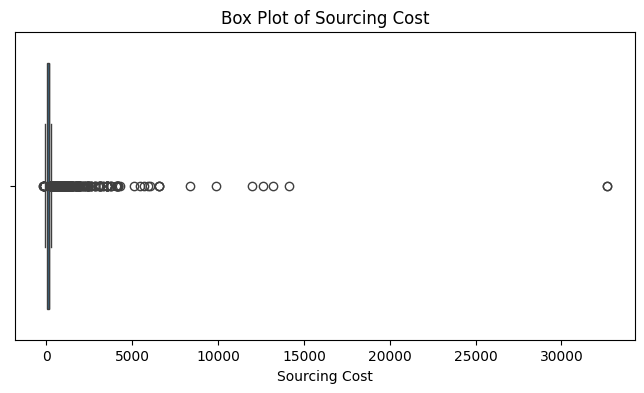

In [6]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='Sourcing Cost', data=train_dataset)
plt.title('Box Plot of Sourcing Cost')
plt.show()

### Removing Outliers using Inter-Quartile Range

In [7]:
# Remove outliers
Q1 = train_dataset['Sourcing Cost'].quantile(0.25)
Q3 = train_dataset['Sourcing Cost'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
train_dataset = train_dataset[(train_dataset['Sourcing Cost'] >= lower_bound) & (train_dataset['Sourcing Cost'] <= upper_bound)]
train_dataset.head()

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost,Year,Month
0,2,0,19,3,1,1,2021-05-01,10.16,2021,5
1,1,0,44,0,1,1,2020-10-01,134.28,2020,10
2,2,1,12,0,1,1,2020-12-01,12.46,2020,12
3,2,0,9,3,2,1,2021-02-01,107.22,2021,2
4,1,0,19,0,1,0,2020-11-01,197.76,2020,11


### Box-Plot of Sourcing Cost after Removing the Outliers

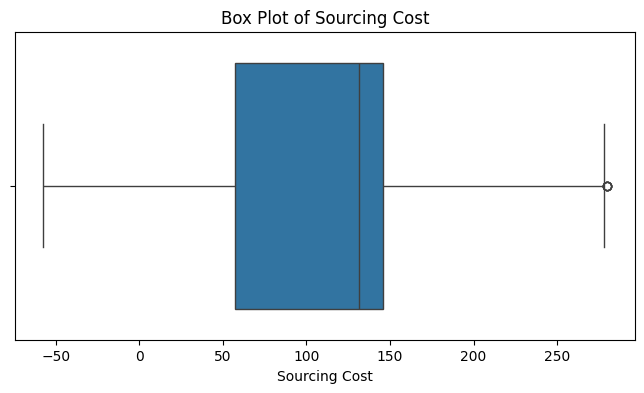

In [8]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='Sourcing Cost', data=train_dataset)
plt.title('Box Plot of Sourcing Cost')
plt.show()

## Exploratory Data Analysis

### Summary of all the data

In [9]:
summary_stats = train_dataset.describe()
print("Summary Statistics:")
print(summary_stats)

Summary Statistics:
         ProductType   Manufacturer      Area Code  Sourcing Channel  \
count  547510.000000  547510.000000  547510.000000     547510.000000   
mean        0.859995       0.255453      22.539831          0.305408   
min         0.000000       0.000000       0.000000          0.000000   
25%         0.000000       0.000000      11.000000          0.000000   
50%         1.000000       0.000000      21.000000          0.000000   
75%         1.000000       0.000000      37.000000          0.000000   
max         2.000000       2.000000      44.000000          3.000000   
std         0.742398       0.474713      14.291543          0.700433   

        Product Size   Product Type              Month of Sourcing  \
count  547510.000000  547510.000000                         547510   
mean        1.393748       0.857137  2020-12-08 07:17:30.128764672   
min         0.000000       0.000000            2020-07-01 00:00:00   
25%         1.000000       1.000000            2020

### Histogram for Count of Sourcing Cost

Text(0.5, 1.0, 'Histogram of Sourcing Cost')

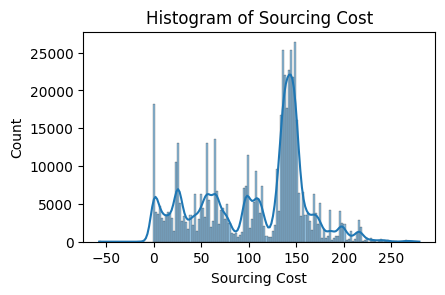

In [10]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
sns.histplot(train_dataset['Sourcing Cost'], kde=True)
plt.title('Histogram of Sourcing Cost')

### Bar Plots for all the features in the given dataset

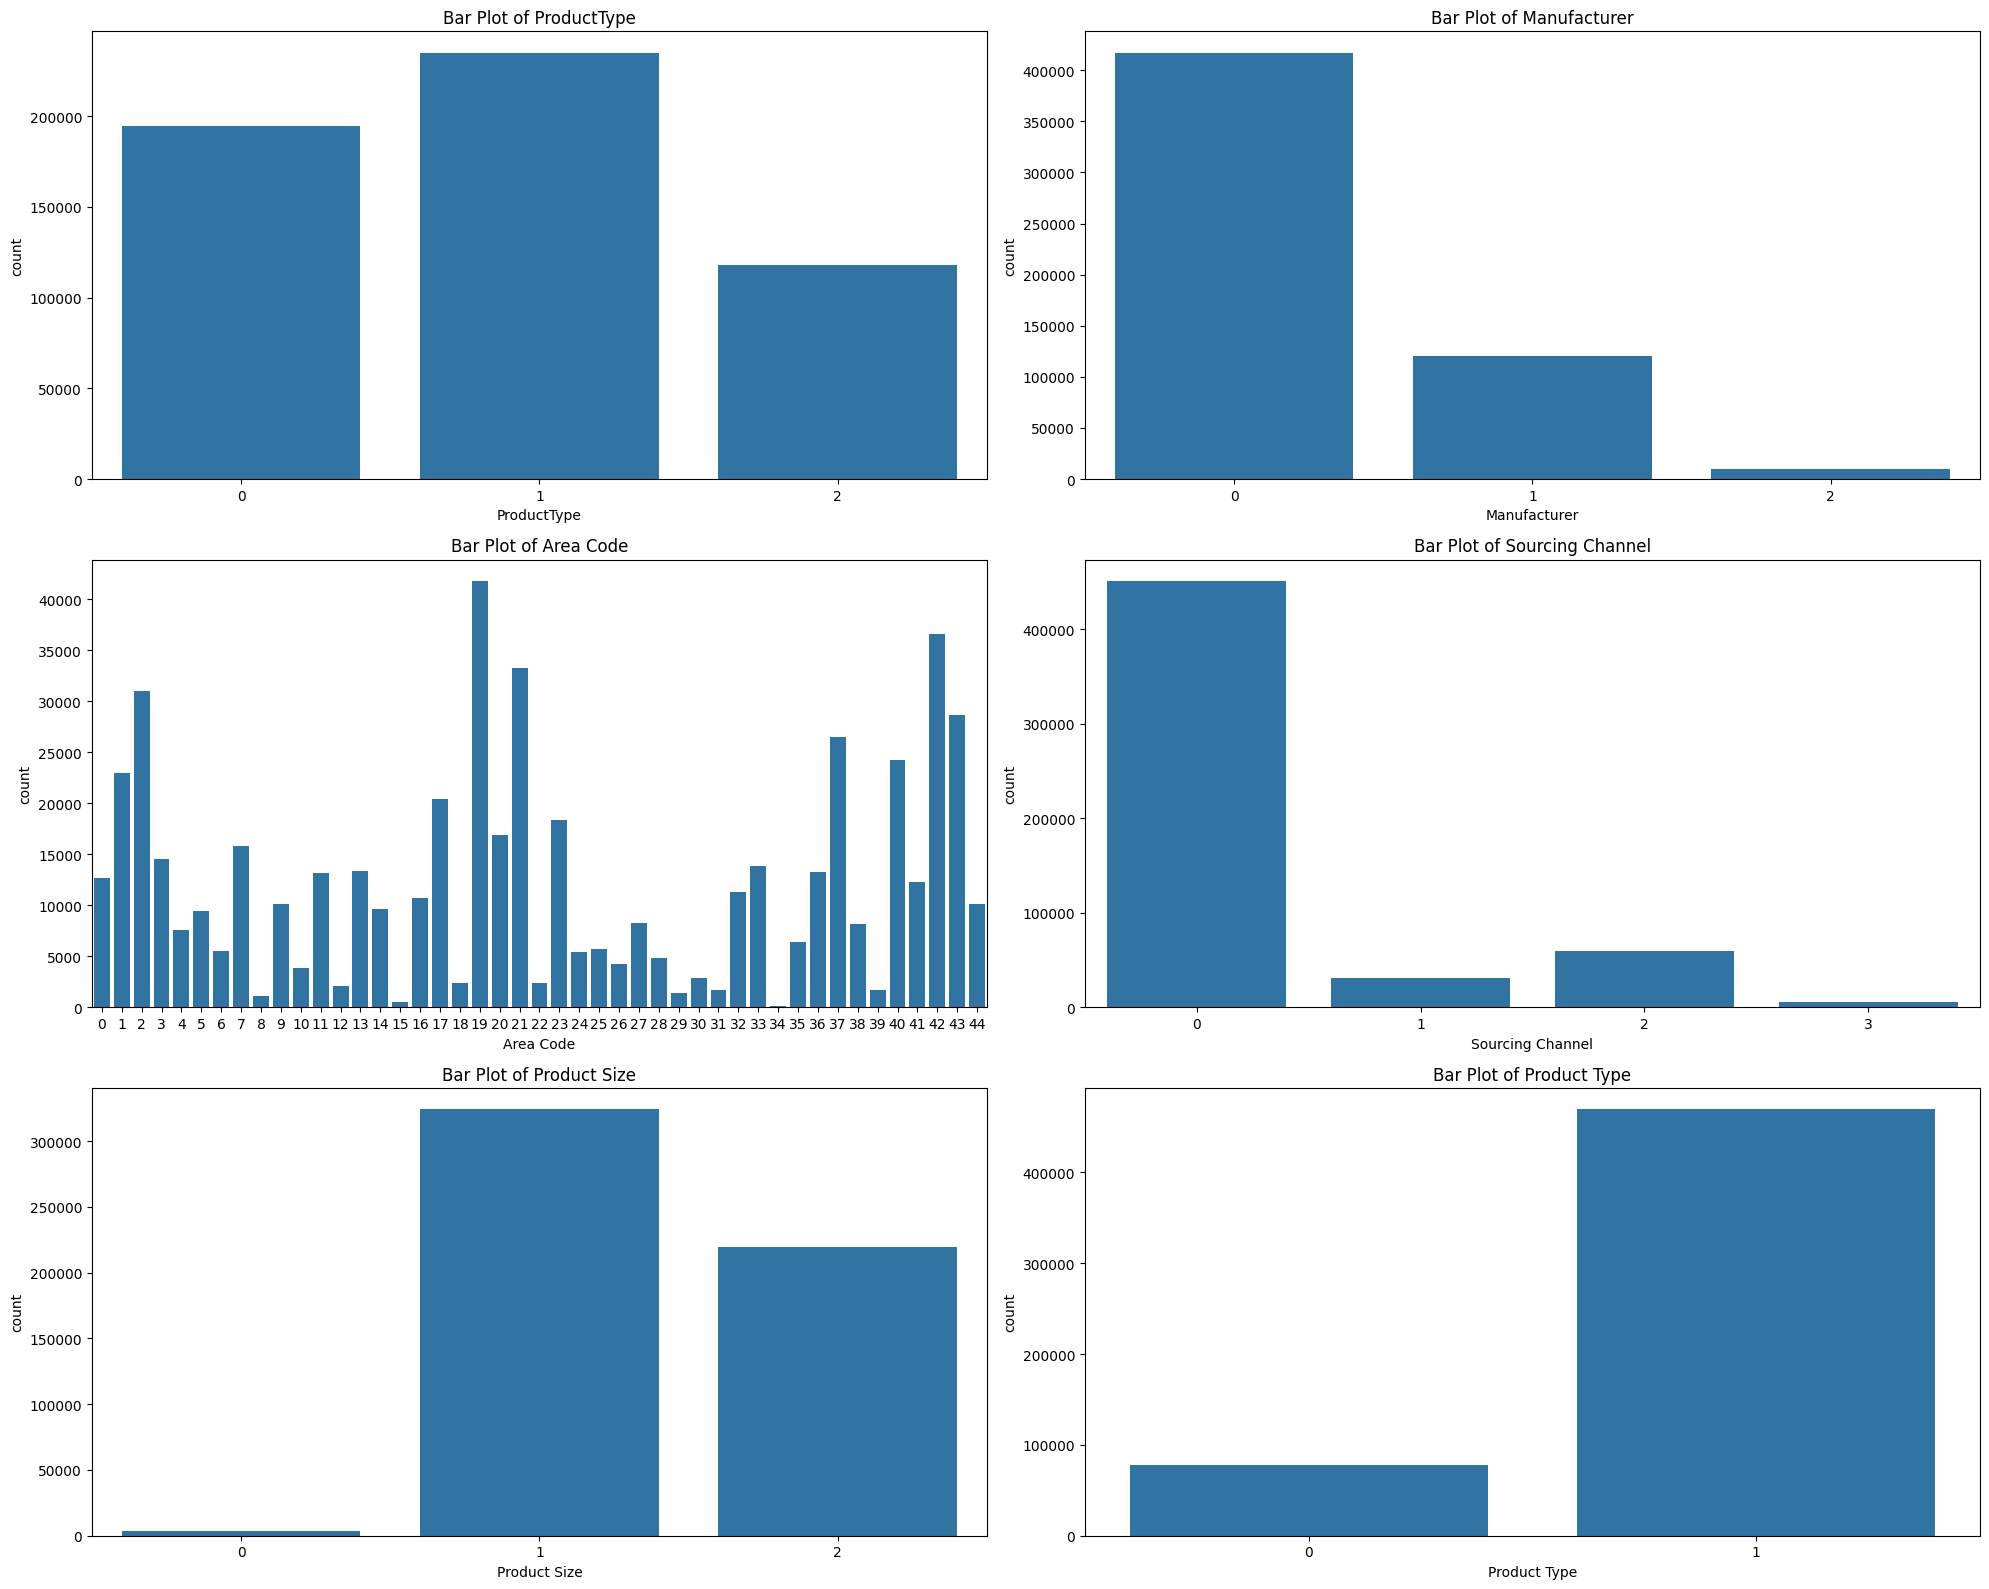

In [11]:
plt.figure(figsize=(20,16))
categorical_features = ['ProductType', 'Manufacturer', 'Area Code', 'Sourcing Channel', 'Product Size', 'Product Type']
for i, feature in enumerate(categorical_features, start=1):
    plt.subplot(3, 2, i)
    sns.countplot(x=feature, data=train_dataset)
    plt.title(f'Bar Plot of {feature}')

plt.tight_layout()
plt.show()

### Scatter Plot for Sourcing Cost for each given month

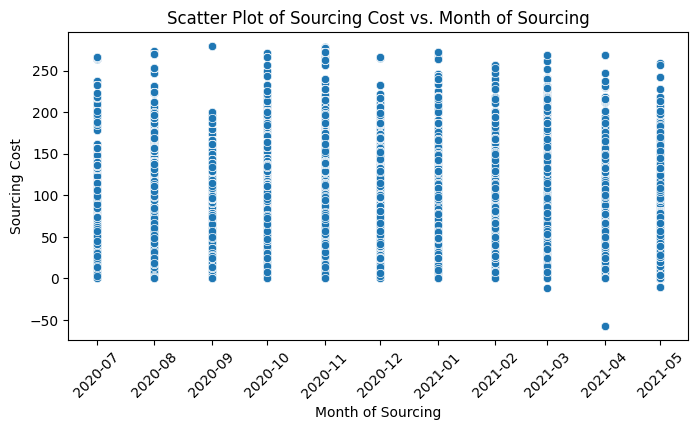

In [12]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x='Month of Sourcing', y='Sourcing Cost', data=train_dataset)
plt.title('Scatter Plot of Sourcing Cost vs. Month of Sourcing')
plt.xticks(rotation=45)
plt.show()

### Pairplots for all the Features

<Figure size 800x800 with 0 Axes>

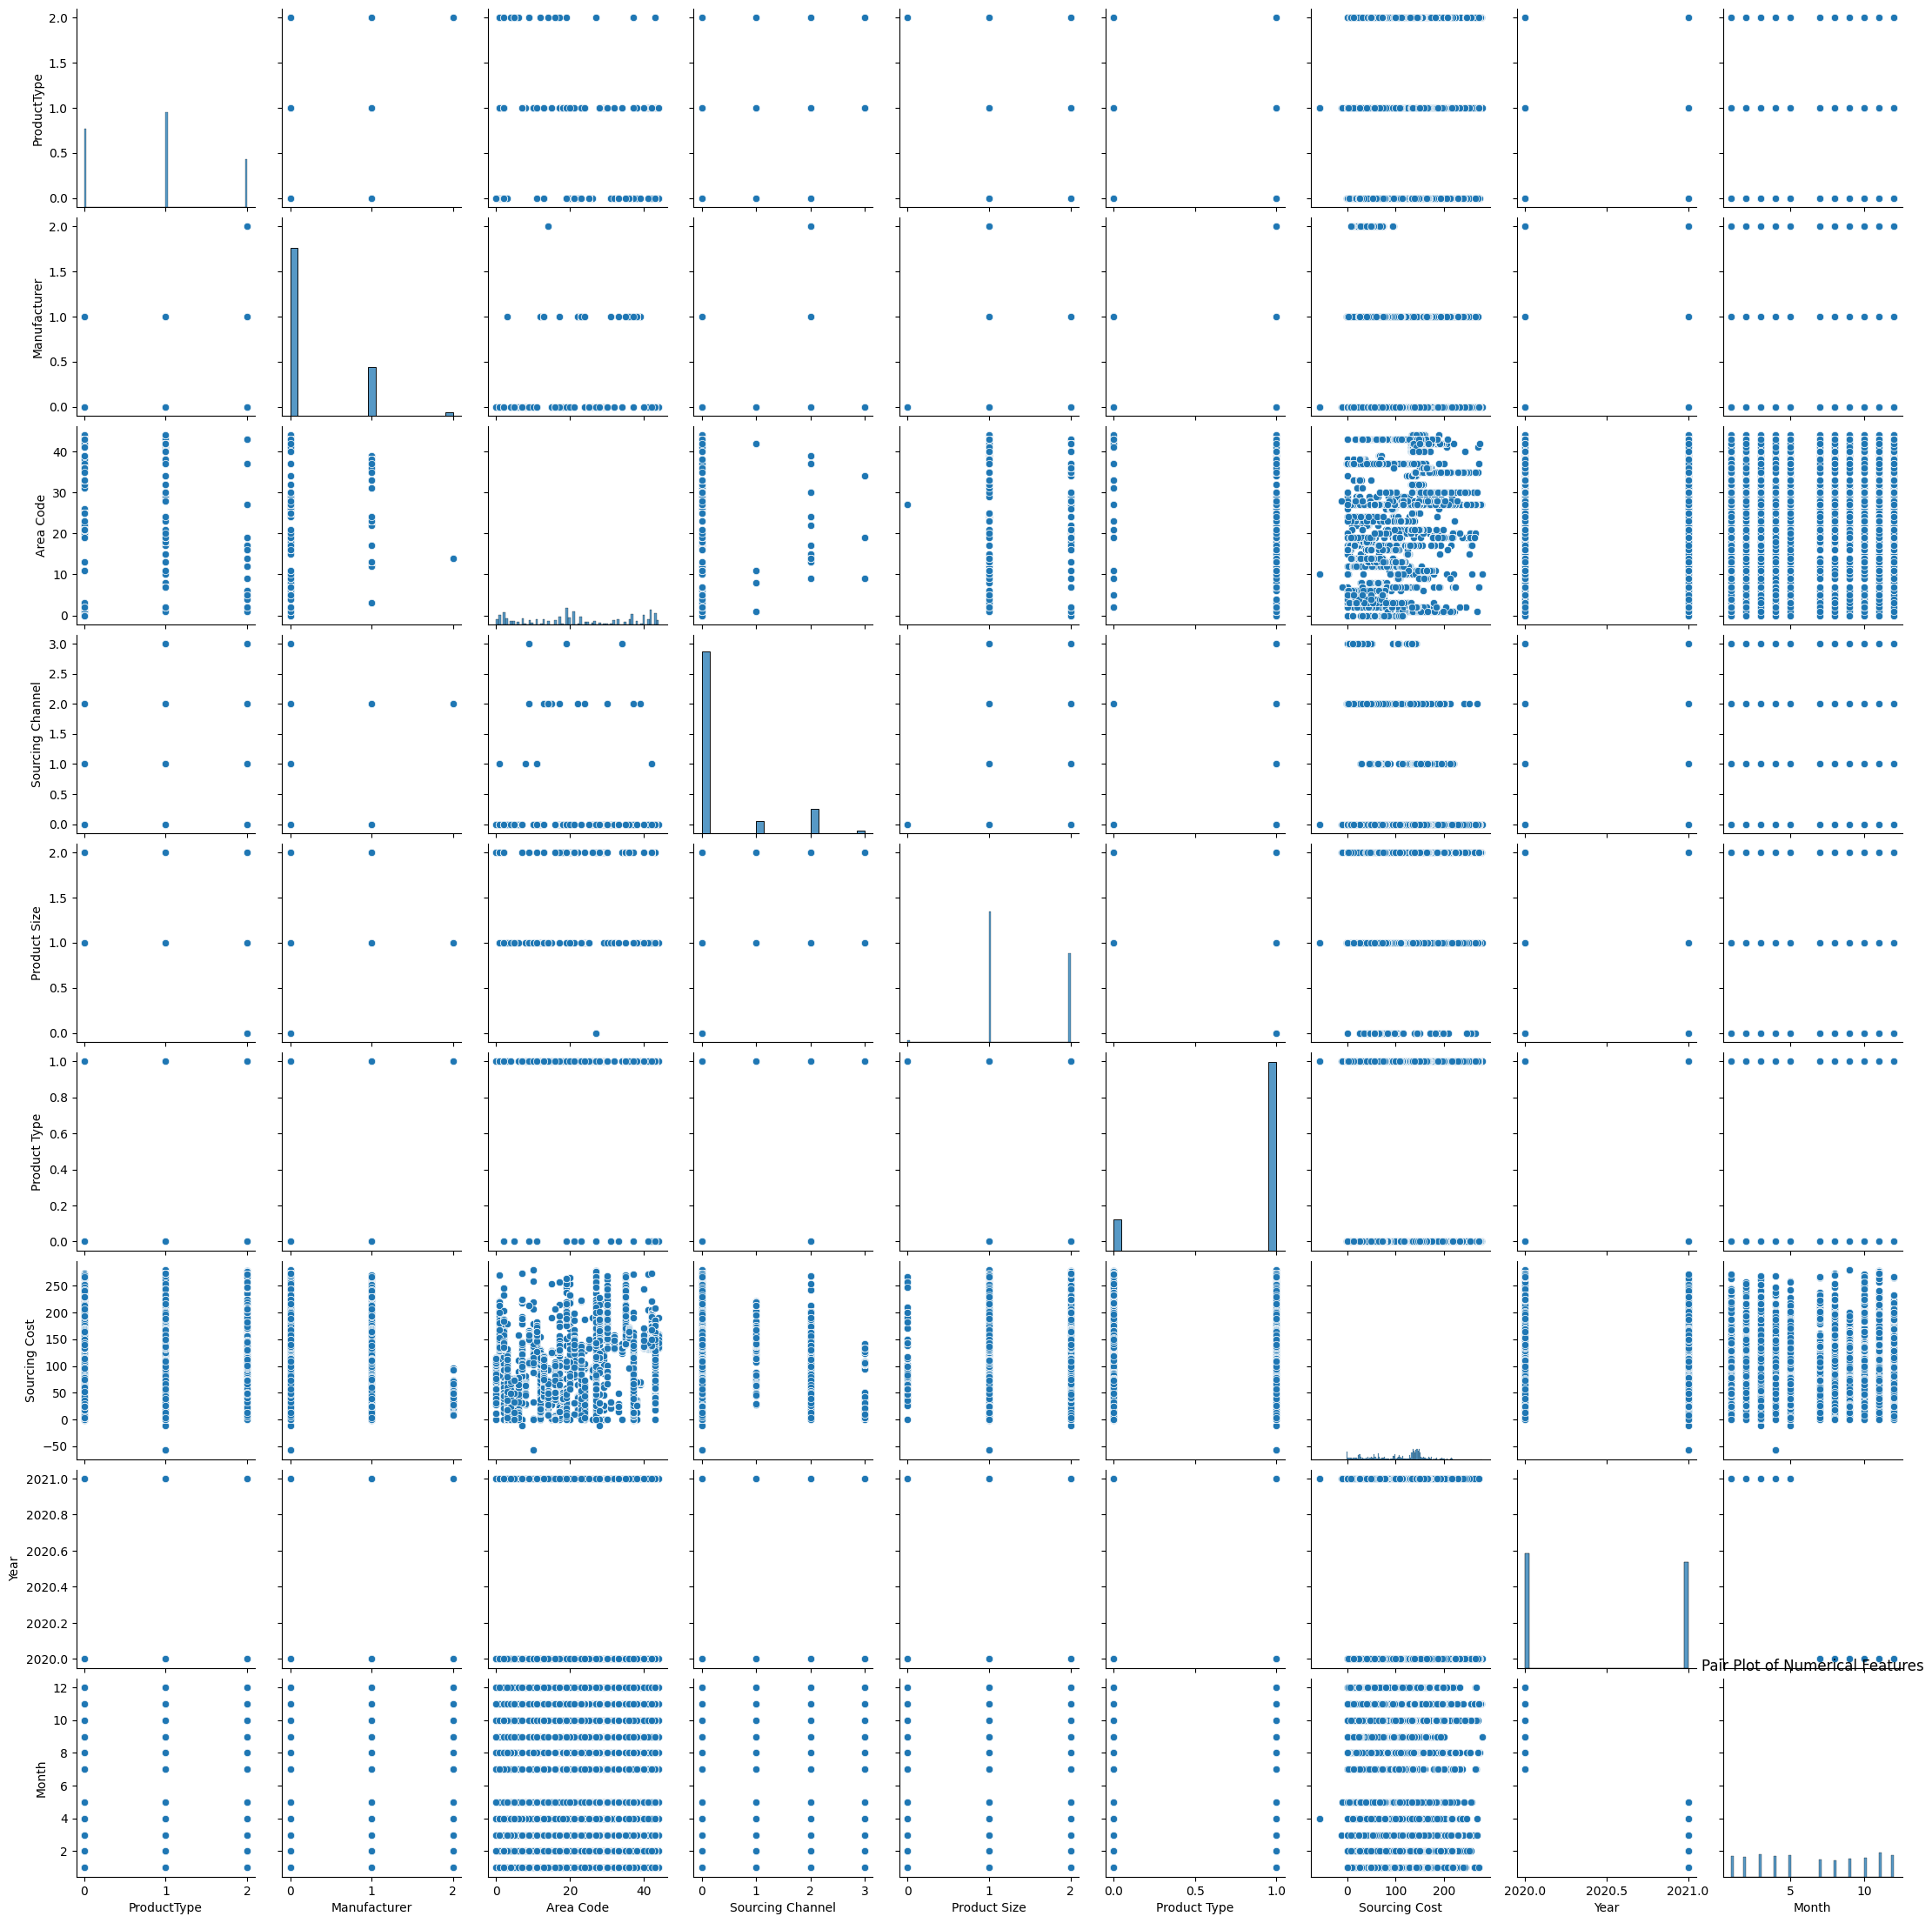

In [13]:
plt.figure(figsize=(8, 8))
sns.pairplot(train_dataset)
plt.title('Pair Plot of Numerical Features')
plt.show()

### Heatmap of Correlation Matrix between all the Features

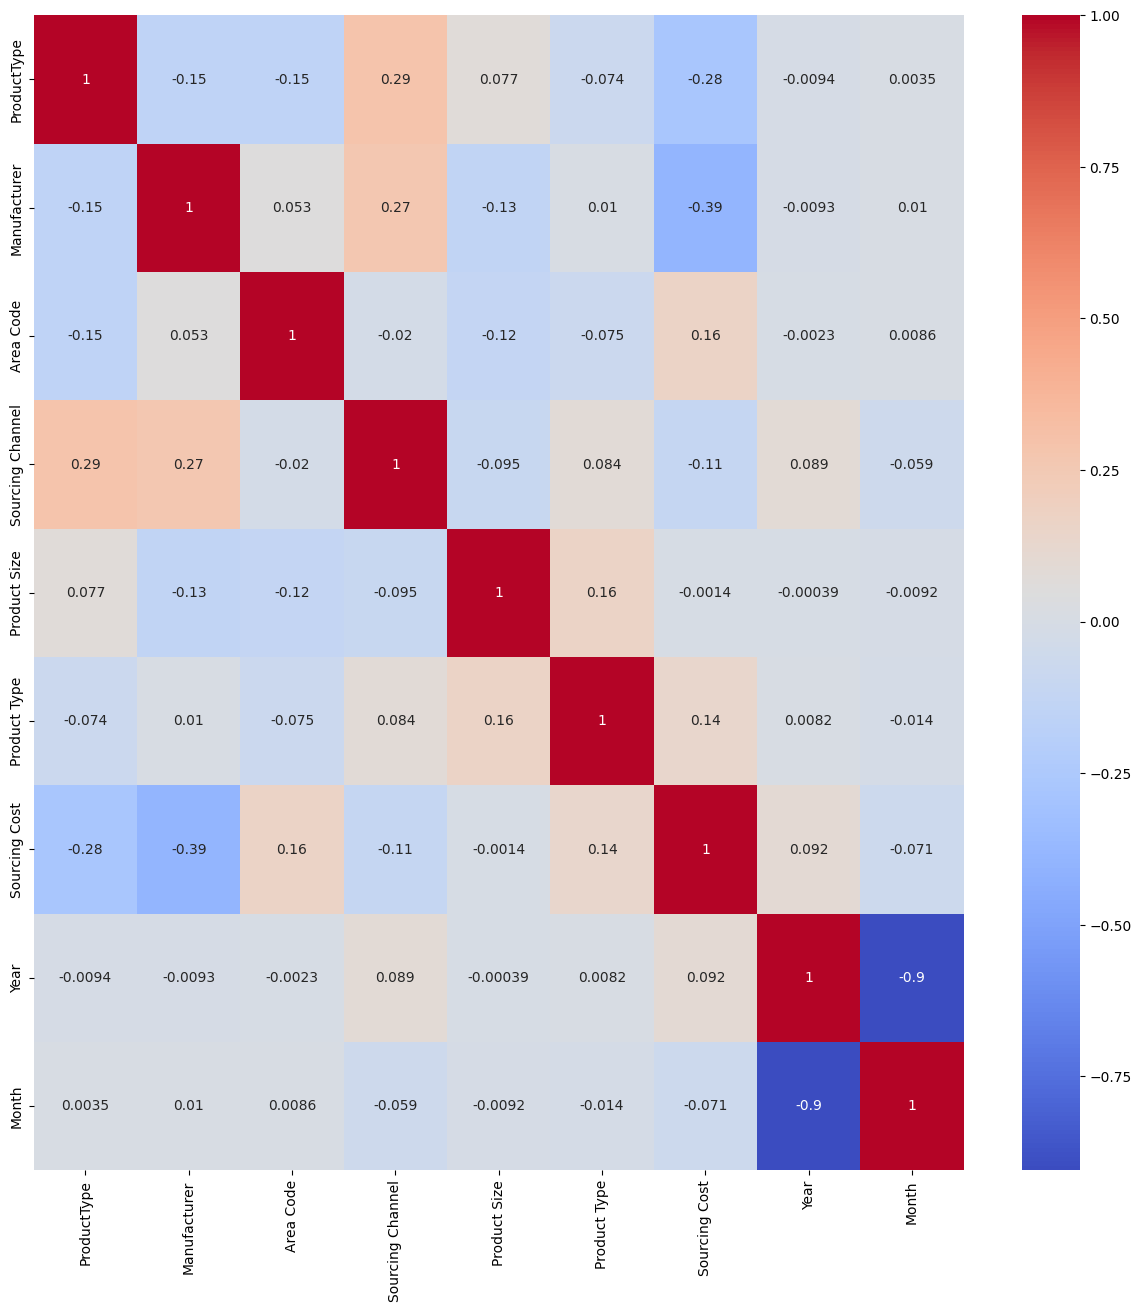

In [14]:
plt.figure(figsize=(15,15))
corr_matrix = train_dataset.drop(columns=["Month of Sourcing"]).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

## Model Training and Validation

### Breaking the Training Data into training and Validation Sets

In [15]:
X = train_dataset.drop(columns=['Sourcing Cost', 'Month of Sourcing'])
y = train_dataset['Sourcing Cost']

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, random_state=42)

### Evaluation Metrics
We will using three metrics for evaluation:
1. Mean Squared Error (MSE): MSE measures the average squared difference between the actual and predicted values in a regression problem.
2. Mean Absolute Error (MAE): MAE measures the average absolute difference between the actual and predicted values in a regression problem.
3. R-Squared Score (R2 Score): R2 score (coefficient of determination) represents the proportion of the variance in the dependent variable that is explained by the independent variables in a regression model.

### Linear Regression
Linear regression is a simple and commonly used statistical technique for modeling the relationship between a dependent variable and one or more independent variables.

In [17]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"Linear Regression Mean Squared Error: {mse}")
print(f"Linear Regression Mean Absolute Error: {mae}")
print(f"Linear Regression R-squared (R2) Score: {r2}")

Linear Regression Mean Squared Error: 2080.465727411948
Linear Regression Mean Absolute Error: 35.904541680663684
Linear Regression R-squared (R2) Score: 0.3277887906905719


### Random Forest Regression
Random forest is an ensemble learning method that constructs a multitude of decision trees during training and outputs the mean prediction of the individual trees for regression tasks.

In [18]:
rfr = RandomForestRegressor(n_estimators = 500, max_depth=100, min_samples_split=8, min_samples_leaf=4, random_state=42)
rfr.fit(X_train,y_train)
y_pred = rfr.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"Random Forest Regression Mean Squared Error: {mse}")
print(f"Random Forest Regression Mean Absolute Error: {mae}")
print(f"Random Forest Regression R-squared (R2) Score: {r2}")

Random Forest Regression Mean Squared Error: 359.8079125945227
Random Forest Regression Mean Absolute Error: 9.020727031069292
Random Forest Regression R-squared (R2) Score: 0.8837438613588016


### Decision Tree Regression
Decision tree regression builds a tree structure where each internal node represents a feature, each branch represents a decision rule, and each leaf node represents the output value.

In [19]:
dtr = DecisionTreeRegressor(max_depth=100, min_samples_split=8, min_samples_leaf=4, random_state=42)
dtr.fit(X_train,y_train)
y_pred = dtr.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"Decision Tree Regression Mean Squared Error: {mse}")
print(f"Decision Tree Regression Mean Absolute Error: {mae}")
print(f"Decision Tree Regression R-squared (R2) Score: {r2}")

Decision Tree Regression Mean Squared Error: 359.7385301794495
Decision Tree Regression Mean Absolute Error: 9.019532744742637
Decision Tree Regression R-squared (R2) Score: 0.8837662792417432


### Gradient Boost Regression
Gradient boosting is an ensemble learning technique that builds a strong predictive model by combining the predictions of multiple weak learners, typically decision trees.

In [20]:
gfr = GradientBoostingRegressor(random_state=42)
gfr.fit(X_train,y_train)
y_pred = gfr.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"Gradient Boost Regression Mean Squared Error: {mse}")
print(f"Gradient Boost Regression Mean Absolute Error: {mae}")
print(f"Gradient Boost Regression R-squared (R2) Score: {r2}")

Gradient Boost Regression Mean Squared Error: 675.2794769591898
Gradient Boost Regression Mean Absolute Error: 16.559550567603026
Gradient Boost Regression R-squared (R2) Score: 0.7818130681762039


### XG Boost Regression
XGBoost (Extreme Gradient Boosting) is an optimized implementation of gradient boosting that uses a more regularized model to control overfitting.

In [21]:
xgbr = XGBRegressor(learning_rate = 0.1, gamma = 0.4, random_state=42)
xgbr.fit(X_train,y_train)
y_pred = xgbr.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"XG Boost Regression Mean Squared Error: {mse}")
print(f"XG Boost Regression Mean Absolute Error: {mae}")
print(f"XG Boost Regression R-squared (R2) Score: {r2}")

XG Boost Regression Mean Squared Error: 388.5218270622364
XG Boost Regression Mean Absolute Error: 10.117940008393516
XG Boost Regression R-squared (R2) Score: 0.8744662198605394


### Ridge Regression
Ridge regression is a linear regression technique that adds a penalty term to the loss function to regularize the coefficients.

In [22]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train,y_train)
y_pred = ridge.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"Ridge Regression Mean Squared Error: {mse}")
print(f"Ridge Regression Mean Absolute Error: {mae}")
print(f"Ridge Regression R-squared (R2) Score: {r2}")

Ridge Regression Mean Squared Error: 2080.46578599049
Ridge Regression Mean Absolute Error: 35.90456835156874
Ridge Regression R-squared (R2) Score: 0.3277887717634864


### Cat Boost Regression
CatBoost is a gradient boosting algorithm that is specifically optimized for categorical features.

In [23]:
cbr = CatBoostRegressor(iterations=1000, learning_rate=0.2, depth=7, verbose = False)
cbr.fit(X_train,y_train)
y_pred = cbr.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"Cat Boost Regression Mean Squared Error: {mse}")
print(f"Cat Boost Regression Mean Absolute Error: {mae}")
print(f"Cat Boost Regression R-squared (R2) Score: {r2}")

Cat Boost Regression Mean Squared Error: 360.45563704502916
Cat Boost Regression Mean Absolute Error: 9.042816087024486
Cat Boost Regression R-squared (R2) Score: 0.8835345776246658


### LightGBM Regression
LightGBM is a gradient boosting framework that uses tree-based learning algorithms.

In [24]:
params = {
    'objective': 'regression',
    'metrics': ['mse', 'mae','r2'],
    'num_leaves': 32,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 18,
    'verbose': -1
}
lgbm = lgb.LGBMRegressor(**params)
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"LightGBM Regression Mean Squared Error: {mse}")
print(f"LightGBM Regression Mean Absolute Error: {mae}")
print(f"LightGBM Regression R-squared (R2) Score: {r2}")

LightGBM Regression Mean Squared Error: 384.3226186339447
LightGBM Regression Mean Absolute Error: 10.107351908699771
LightGBM Regression R-squared (R2) Score: 0.8758230098035469


### Choosing the best models
Based on the values of the Mean Squared Error, Mean Absolute Error and R2 Score, the best models found using validation are:
#### 1. Random Forest Regression
#### 2. Decision Tree Regression
#### 3. Cat Boost regression
#### 4. XG Boost Regression
#### 5. LightGBM Regression
In these, the first four regression models have very similar values but LightGBM Regression has a little higher error and lower r2 score but very nearby so that is why we consider it.

## Testing

### Importing the Test Data

In [25]:
test_dataset = pd.read_csv("dataset/Test Dataset.csv")

### Preprocessing steps on the Test Data

In [26]:
test_dataset.dropna(inplace=True)

In [27]:
test_dataset['Month of Sourcing'] = pd.to_datetime(test_dataset['Month of Sourcing'], format='%b-%y')
test_dataset['Year'] = test_dataset['Month of Sourcing'].dt.year
test_dataset['Month'] = test_dataset['Month of Sourcing'].dt.month

In [29]:
for column in test_dataset.columns:
    if test_dataset.dtypes[column] == 'object':
        encoder = encoders[column]
        test_dataset[column] = encoder.transform(test_dataset[column])

In [30]:
test_input = test_dataset.drop(columns=['Sourcing Cost', 'Month of Sourcing'])
test_output = test_dataset["Sourcing Cost"]

## Predictions using the Best Models from Above

### Random Forest Regression

In [31]:
y_pred = rfr.predict(test_input)
mse = mean_squared_error(test_output, y_pred)
mae = mean_absolute_error(test_output, y_pred)
r2 = r2_score(test_output, y_pred)
print(f"Random Forest Regression Mean Squared Error: {mse}")
print(f"Random forest Regression Mean Absolute Error: {mae}")
print(f"Random Forest Regression R-squared (R2) Score: {r2}")

Random Forest Regression Mean Squared Error: 1062.7088257261987
Random forest Regression Mean Absolute Error: 16.442060671377888
Random Forest Regression R-squared (R2) Score: 0.6082840979738033


### XG Boost Regression

In [32]:
y_pred = xgbr.predict(test_input)
mse = mean_squared_error(test_output, y_pred)
mae = mean_absolute_error(test_output, y_pred)
r2 = r2_score(test_output, y_pred)
print(f"XG Boost Regression Mean Squared Error: {mse}")
print(f"XG Boost Regression Mean Absolute Error: {mae}")
print(f"XG Boost Regression R-squared (R2) Score: {r2}")

XG Boost Regression Mean Squared Error: 958.5434011486624
XG Boost Regression Mean Absolute Error: 15.689989303747813
XG Boost Regression R-squared (R2) Score: 0.646679613528545


### Decision Tree Regression

In [33]:
y_pred = dtr.predict(test_input)
mse = mean_squared_error(test_output, y_pred)
mae = mean_absolute_error(test_output, y_pred)
r2 = r2_score(test_output, y_pred)
print(f"Decision Tree Regression Mean Squared Error: {mse}")
print(f"Decision Tree Regression Mean Absolute Error: {mae}")
print(f"Decision Tree Regression R-squared (R2) Score: {r2}")

Decision Tree Regression Mean Squared Error: 1073.8118238199434
Decision Tree Regression Mean Absolute Error: 16.51056227204173
Decision Tree Regression R-squared (R2) Score: 0.6041915179479301


### Cat Boost Regression

In [34]:
y_pred = cbr.predict(test_input)
mse = mean_squared_error(test_output, y_pred)
mae = mean_absolute_error(test_output, y_pred)
r2 = r2_score(test_output, y_pred)
print(f"Cat Boost Regression Mean Squared Error: {mse}")
print(f"Cat Boost Regression Mean Absolute Error: {mae}")
print(f"Cat Boost Regression R-squared (R2) Score: {r2}")

Cat Boost Regression Mean Squared Error: 1050.0647422836994
Cat Boost Regression Mean Absolute Error: 16.45480111917508
Cat Boost Regression R-squared (R2) Score: 0.6129447241312918


### LightGBM Regerssion

In [35]:
y_pred = lgbm.predict(test_input)
mse = mean_squared_error(test_output, y_pred)
mae = mean_absolute_error(test_output, y_pred)
r2 = r2_score(test_output, y_pred)
print(f"LightGBM Regression Mean Squared Error: {mse}")
print(f"LightGBM Regression Mean Absolute Error: {mae}")
print(f"LightGBM Regression R-squared (R2) Score: {r2}")

LightGBM Regression Mean Squared Error: 1035.3239676620985
LightGBM Regression Mean Absolute Error: 16.624323078532502
LightGBM Regression R-squared (R2) Score: 0.6183781934764996


### Model Evaluation based on Testing
From Testing we can see that the XGBoost Regression works very well with Cat Boost Regression and LightGBM Regression very nearby, whereas the Random Forest Regression and Decision Tree Regression perform a little bad compared to the above models

## Final Approach
Based on the evalution from validation and testing, we can say that XG Boost Regression model works best compared to any other model used, so I am going to use the XG Boost model.
I will be saving the labelencoder and model into .pkl files so that they can be used in the python code which is deployed on Streamlit on the website: https://forecasting-sourcing-data.streamlit.app/

In [36]:
import pickle
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)
with open('model.pkl', 'wb') as f:
    pickle.dump(xgbr, f)